In [21]:
from datasets import load_dataset
import datasets

In [27]:
datasets.__dict__

{'__name__': 'datasets',
 '__doc__': None,
 '__package__': 'datasets',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x1f98e3357f0>,
 '__spec__': ModuleSpec(name='datasets', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000001F98E3357F0>, origin='c:\\Users\\user\\anaconda3\\Lib\\site-packages\\datasets\\__init__.py', submodule_search_locations=['c:\\Users\\user\\anaconda3\\Lib\\site-packages\\datasets']),
 '__path__': ['c:\\Users\\user\\anaconda3\\Lib\\site-packages\\datasets'],
 '__file__': 'c:\\Users\\user\\anaconda3\\Lib\\site-packages\\datasets\\__init__.py',
 '__cached__': 'c:\\Users\\user\\anaconda3\\Lib\\site-packages\\datasets\\__pycache__\\__init__.cpython-312.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis mo

In [42]:
ds = load_dataset('beans')

In [43]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

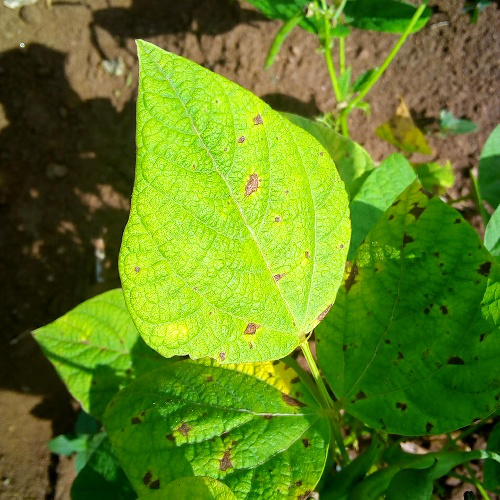

In [44]:
ds['train'][100]['image']

In [45]:
ds['train'].features['labels']

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [46]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image
import torch
import numpy as np
from datasets import load_metric
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer

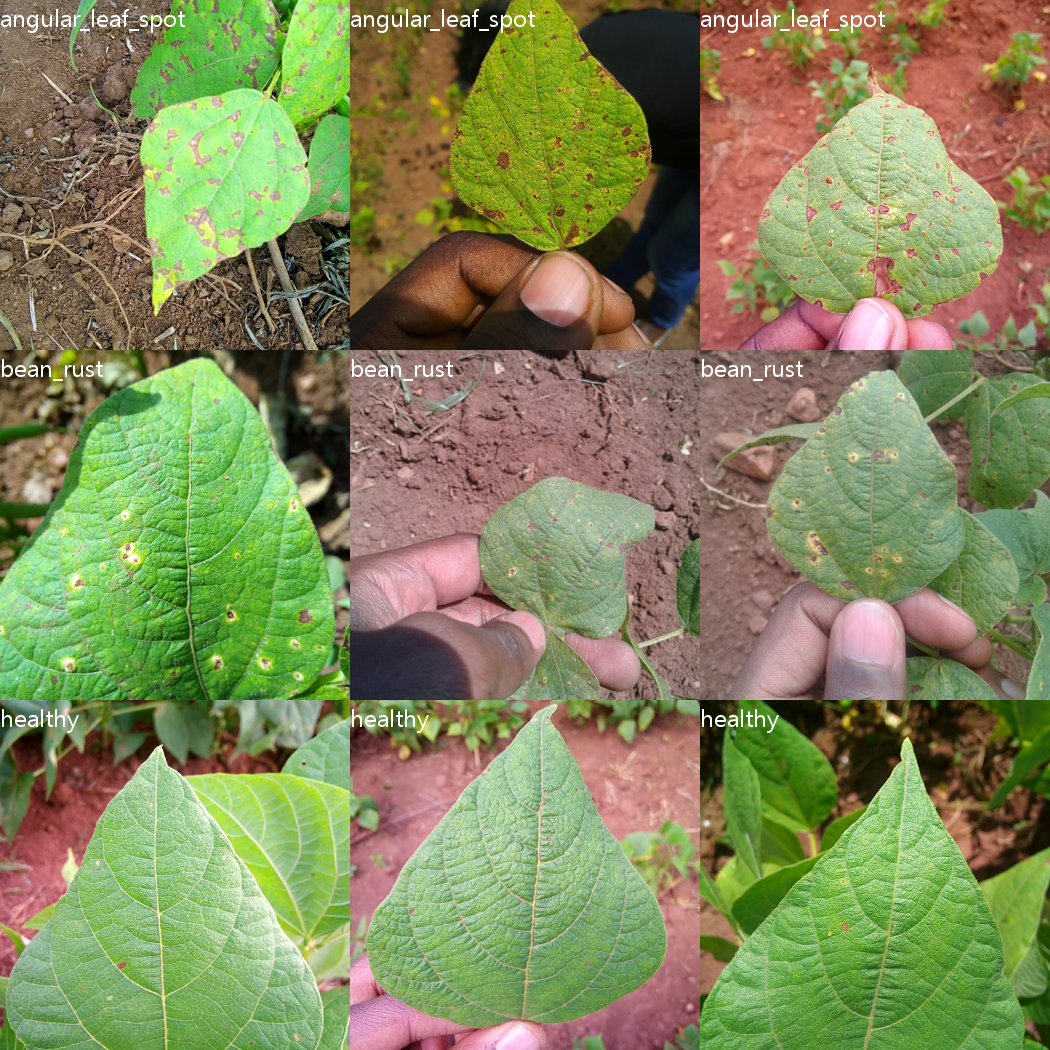

In [47]:
# 랜덤으로 시각화해서 무슨 병이 있는지 보기.
def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):
    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("malgun.ttf", 24)

    for label_id, label in enumerate(labels):

        # 종류별로 데이터를 가져오고, 섞어서 몇 가지 샘플을 보여주도록 합니다
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # 각 행을 따라 시각화합니다
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [48]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'

# feature extractor 알아두기. 모델들은 모델 이름과 같은 extractor를 하나씩 가지고 있으므로 이용할 것.
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

loading configuration file preprocessor_config.json from cache at C:\Users\user\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k\snapshots\b4569560a39a0f1af58e3ddaf17facf20ab919b0\preprocessor_config.json
c:\Users\user\anaconda3\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}, {'max_width', 'max_height'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_f

In [49]:
# feature extractor로 한 장만 바꿔 보기
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt') 
    # pt : 파이토치, 파이토치의 텐서 형태로 변환한다는 뜻, 하는 이유는 딥러닝 모델에 집어넣기 좋게 하기 위해
    inputs['labels'] = example['labels']
    return inputs

In [50]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1922, -0.2549],
          [-0.6078, -0.6000, -0.5843,  ..., -0.0353, -0.0196, -0.2706],
          [-0.6314, -0.6314, -0.6157,  ..., -0.2392, -0.3647, -0.2314],
          ...,
          [-0.5373, -0.5529, -0.5765,  ..., -0.0745, -0.0431, -0.0980],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3176,  0.1608,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2784,  0.1451,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3569, -0.3176, -0.5608],
          [-0.7490, -0.7490, -0.7647,  ..., -0.5373, -0.6627, -0.5373],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.2314, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1843,  0.3176,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0745,  0.2863,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3647, -0.7333],
          [-0

In [51]:
# feature extractor 일괄 적용하는 함수 정의
def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    inputs['labels'] = example_batch['labels']

    return inputs


In [52]:
# ds에 함수 적용
prepared_ds = ds.with_transform(transform)

In [53]:
prepared_ds['train'][0]

{'pixel_values': tensor([[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1922, -0.2549],
          [-0.6078, -0.6000, -0.5843,  ..., -0.0353, -0.0196, -0.2706],
          [-0.6314, -0.6314, -0.6157,  ..., -0.2392, -0.3647, -0.2314],
          ...,
          [-0.5373, -0.5529, -0.5765,  ..., -0.0745, -0.0431, -0.0980],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3176,  0.1608,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2784,  0.1451,  0.2000]],
 
         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3569, -0.3176, -0.5608],
          [-0.7490, -0.7490, -0.7647,  ..., -0.5373, -0.6627, -0.5373],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.2314, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1843,  0.3176,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0745,  0.2863,  0.3961]],
 
         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3647, -0.7333],
          [-

In [54]:
def collate_fn(batch):
    return {
        'pixel_values':torch.stack([x['pixel_values'] for x in batch]),
        'labels' : torch.tensor([x['labels'] for x in batch]),
    }

In [55]:
metric = load_metric('accuracy', trust_remote_code=True)

# compute : 계산한다
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references = p.label_ids)

In [56]:
labels = ds['train'].features['labels'].names

In [57]:
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels = len(labels),
    id2label = {str(i) : c for i,c in enumerate(labels)},
    label2id = {c : str(i) for i,c in enumerate(labels)}
)

loading configuration file config.json from cache at C:\Users\user\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k\snapshots\b4569560a39a0f1af58e3ddaf17facf20ab919b0\config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "angular_leaf_spot",
    "1": "bean_rust",
    "2": "healthy"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "angular_leaf_spot": "0",
    "bean_rust": "1",
    "healthy": "2"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.44.2"
}

loading weights file model.safetensors from cache at C:\Users\user\.cache\h

In [58]:
training_args = TrainingArguments(
    output_dir= './',
    per_device_train_batch_size=16,
    eval_strategy='steps',
    num_train_epochs=2,
    fp16=True, # 부동소수점 16비트 쓸 것인가.
    save_steps=100, # 100스텝마다 저장
    eval_steps=100, # 100스텝마다 평가
    logging_steps=10, # 10스텝마다 기록남김
    learning_rate=0.01,
    save_total_limit=2, # 2개까지 저장
    remove_unused_columns=False, # 안 쓰인 열 지움 = false
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True, # 제일 좋은 모델 로드
)

PyTorch: setting up devices


In [59]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds['train'],
    eval_dataset=prepared_ds['validation'],
    tokenizer=feature_extractor,
)

c:\Users\user\anaconda3\Lib\site-packages\accelerate\accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Using auto half precision backend


In [60]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics('train', train_results.metrics)
trainer.save_metrics('train', train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 1,034
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 130
  Number of trainable parameters = 85,800,963


  0%|          | 0/130 [00:00<?, ?it/s]

c:\Users\user\anaconda3\Lib\site-packages\transformers\models\vit\modeling_vit.py:252: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


{'loss': 1.2963, 'grad_norm': 2.84709095954895, 'learning_rate': 0.009230769230769232, 'epoch': 0.15}
{'loss': 1.2887, 'grad_norm': 1.1892168521881104, 'learning_rate': 0.008461538461538461, 'epoch': 0.31}
{'loss': 1.2044, 'grad_norm': 0.7593328356742859, 'learning_rate': 0.007692307692307693, 'epoch': 0.46}
{'loss': 1.1784, 'grad_norm': 0.4686053693294525, 'learning_rate': 0.006923076923076923, 'epoch': 0.62}
{'loss': 1.1159, 'grad_norm': 0.24231581389904022, 'learning_rate': 0.006153846153846155, 'epoch': 0.77}
{'loss': 1.1073, 'grad_norm': 0.3022061288356781, 'learning_rate': 0.005384615384615384, 'epoch': 0.92}
{'loss': 1.0946, 'grad_norm': 0.924290657043457, 'learning_rate': 0.004615384615384616, 'epoch': 1.08}
{'loss': 1.1367, 'grad_norm': 0.17809896171092987, 'learning_rate': 0.0038461538461538464, 'epoch': 1.23}
{'loss': 1.1007, 'grad_norm': 0.08068367838859558, 'learning_rate': 0.0030769230769230774, 'epoch': 1.38}



***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


{'loss': 1.0989, 'grad_norm': 0.23780612647533417, 'learning_rate': 0.002307692307692308, 'epoch': 1.54}


  0%|          | 0/17 [00:00<?, ?it/s]

Saving model checkpoint to ./checkpoint-100
Configuration saved in ./checkpoint-100\config.json
Model weights saved in ./checkpoint-100\model.safetensors


{'eval_loss': 1.100380301475525, 'eval_accuracy': 0.3308270676691729, 'eval_runtime': 4.1982, 'eval_samples_per_second': 31.68, 'eval_steps_per_second': 4.049, 'epoch': 1.54}


Image processor saved in ./checkpoint-100\preprocessor_config.json


{'loss': 1.1084, 'grad_norm': 0.09965241700410843, 'learning_rate': 0.0015384615384615387, 'epoch': 1.69}
{'loss': 1.0993, 'grad_norm': 0.0778585821390152, 'learning_rate': 0.0007692307692307693, 'epoch': 1.85}


Saving model checkpoint to ./checkpoint-130
Configuration saved in ./checkpoint-130\config.json


{'loss': 1.0988, 'grad_norm': 0.21382629871368408, 'learning_rate': 0.0, 'epoch': 2.0}


Model weights saved in ./checkpoint-130\model.safetensors
Image processor saved in ./checkpoint-130\preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./checkpoint-100 (score: 1.100380301475525).
Saving model checkpoint to ./
Configuration saved in ./config.json


{'train_runtime': 199.9564, 'train_samples_per_second': 10.342, 'train_steps_per_second': 0.65, 'train_loss': 1.1483354788560134, 'epoch': 2.0}


Model weights saved in ./model.safetensors
Image processor saved in ./preprocessor_config.json


***** train metrics *****
  epoch                    =         2.0
  total_flos               = 149248978GF
  train_loss               =      1.1483
  train_runtime            =  0:03:19.95
  train_samples_per_second =      10.342
  train_steps_per_second   =        0.65


In [61]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


  0%|          | 0/17 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.3308
  eval_loss               =     1.1004
  eval_runtime            = 0:00:04.24
  eval_samples_per_second =     31.363
  eval_steps_per_second   =      4.009
